# Demo 4: Monitor class disentanglement

In [2]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import torch

from hnne import HNNE

In [3]:
!git clone git@github.com:huyvnphan/PyTorch_CIFAR10.git

fatal: destination path 'PyTorch_CIFAR10' already exists and is not an empty directory.


In [4]:
from PyTorch_CIFAR10.cifar10_models import resnet

## Load the ResNet18 network and CIFAR-10

In [5]:
device = torch.device('cpu')
resnet_cifar = resnet.resnet18(pretrained=True)
resnet_cifar.eval()

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2471, 0.2435, 0.2616))
])

layers = list(resnet_cifar.children())
initial_conv = torch.nn.Sequential(*layers[:4])
intermediate_blocks = layers[4:8]

In [6]:
cifar10_train = CIFAR10(root='.', download=True, train=True)
cifar10_test = CIFAR10(root='.', download=True, train=True)

Files already downloaded and verified
Files already downloaded and verified


## Extract values of all intermediate blocks

In [7]:
intermediate_outputs = [[], [], [], [], []]
total = 2000
cnt = 0

for img, label in tqdm(cifar10_train, total=total-1):
    with torch.no_grad():
        img = transform(img).unsqueeze(0)
        output = initial_conv(img)
        intermediate_outputs[0].append(output)
        for i, block in enumerate(intermediate_blocks, start=1):
            output = block(output)
            intermediate_outputs[i].append(output)

    cnt += 1
    if cnt >= total:
        break
        
for i in range(len(intermediate_outputs)):
    intermediate_outputs[i] = torch.vstack(intermediate_outputs[i]).cpu().detach().numpy().reshape((total, -1))

100%|██████████| 1999/1999 [00:52<00:00, 38.12it/s]


## Project the data and all intermediate outputs with h-NNE

In [8]:
%%time
hnne = HNNE()
projection_data = hnne.fit_transform(cifar10_train.data[:total].reshape(-1, 32*32*3))

CPU times: user 4.06 s, sys: 2.03 s, total: 6.09 s
Wall time: 2.45 s


In [9]:
%%time
intermediate_projections = [[], [], [], [], []]
for i in range(len(intermediate_outputs)):
    intermediate_projections[i] = HNNE().fit_transform(intermediate_outputs[i])

CPU times: user 34.2 s, sys: 14.7 s, total: 49 s
Wall time: 19.8 s


## Plot the embeddings
One can observe how the separation of targets in different clusters reflects the increasing quality of the features as one goes deeper through the network.

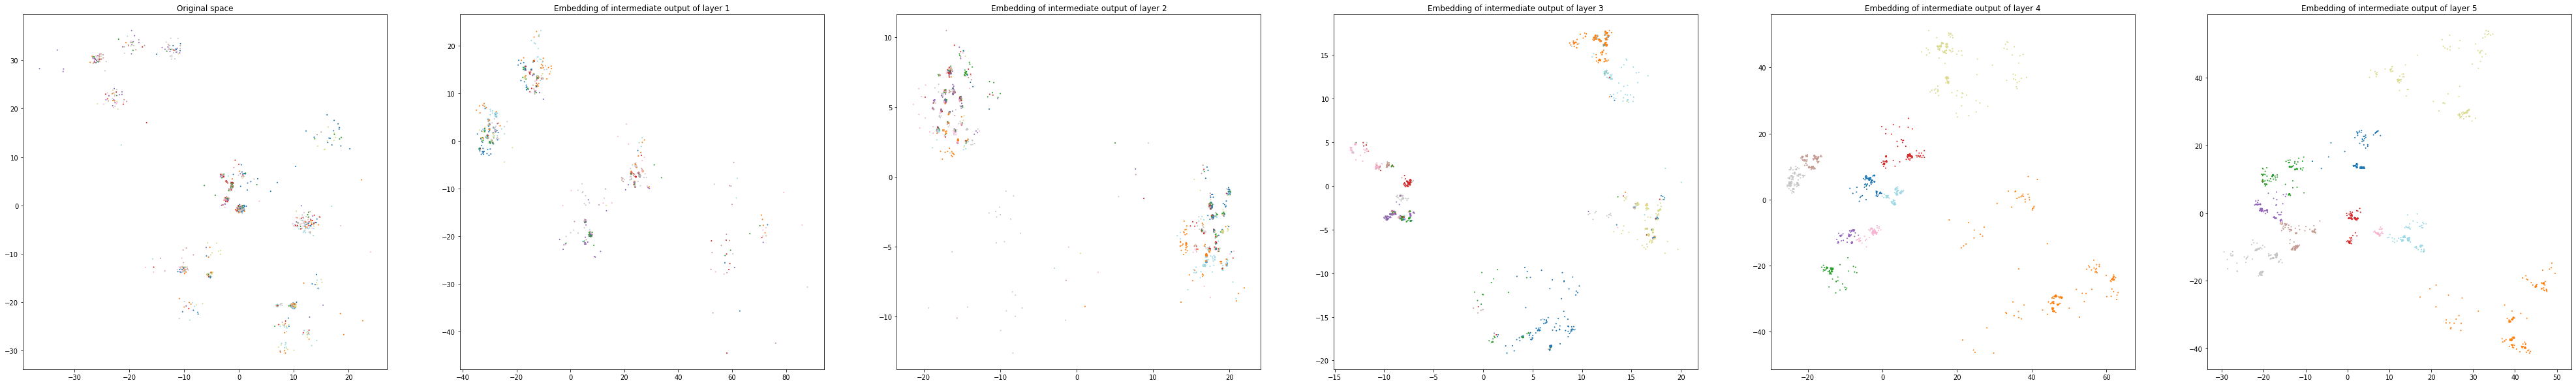

In [10]:
_, ax = plt.subplots(1, 6, figsize=(10*(6 + 1), 10))

ax[0].set_title('Original space')
ax[0].scatter(*projection_data.T, s=1, c=cifar10_train.targets[:total], cmap='tab20')

for i, intermediate in enumerate(intermediate_projections, start=1):
    ax[i].set_title(f'Embedding of intermediate output of layer {i}')
    ax[i].scatter(*intermediate.T, s=1, c=cifar10_train.targets[:total], cmap='tab20')
plt.show()